# THE VERTEX COVER PROBLEM WITH APPLICATION IN CYBER SECURITY

# _Link Monitoring for Internet-of-Things-Enabled Wireless Sensor Networks_

**_Demonstration is partly based on work published May 2022 [[1](#WSN)]_**


# Intorduction

Wireless sensor networks (WSNs) achieving environmental sensing are fundamental communication layer technologies in the Internet of Things.

Wireless Sensor Networks (WSNs) have become a cornerstone of modern technology, enabling real-time data collection and communication across a myriad of applications, from environmental monitoring to industrial automation.

However, ensuring seamless connectivity while optimizing energy consumption remains a critical challenge.

**_<div class="alert alert-success">In this demonstration, we delve into a technique for tackling this challenge: solving WSN link monitoring through the lens of the Minimum Vertex Cover problem using Classiq</div>_**


# The Link Monitoring Problem:

Wireless sensor networks (WSNs) do not have a predefined structure to maintain fundamental data-transfer operations. They are crucial communication layer technologies for providing environmental sensing operations in the Internet of Things (IoT). Most of the time, WSNs are deployed for various applications in forests, mines and land borders, where they should bear harsh circumstances.

Link monitoring in WSNs involves identifying the optimal set of communication links between sensors to guarantee reliable data transmission while minimizing energy usage. As the network scales, manually selecting these links becomes increasingly complex and time-consuming. This is where the concept of graph theory and the Minimum Vertex Cover problem step in.

## Graph Modeling

To effectively address the link monitoring challenge, we leverage graph theory to model the WSN. Each sensor is represented as a node, and communication links between sensors are depicted as edges. This graphical representation captures the essence of connectivity in the network, providing a foundation for optimizing link monitoring.

A WSN can be modeled as a graph $G(V,E)$, where $V$ and $E$ represent the set of vertices (nodes) and edges (communication links), respectively. A vertex cover of a given undirected graph $G(V,E)$ is a set $S ⊆ V$ such that each $e \in E$ is incident to at least one vertex of $S$.

## Minimum Vertex Cover Concept:

At the heart of our approach lies the concept of Minimum Vertex Cover [[2](#MVC)]. This optimization problem aims to find the smallest subset of nodes (vertices) in a graph such that every edge in the graph is incident to at least one of these nodes. In the context of WSNs, the vertices selected for the minimum vertex cover represent the critical sensors that ensure seamless communication throughout the network.

**_<div class="alert alert-success">Vertex cover is a very useful structure for various WSN applications such as routing, clustering, backbone formation, link monitoring, replica management, network attack protection, etc</div>_**

Considering the link monitoring application, the number of monitor nodes should be minimized since they should be equipped with extra software/hardware solutions to monitor the network traffic. On the other side, the optimization version of the minimum vertex cover problem, which aims to solve the problem by selecting the minimum number of nodes to cover the whole graph, is in the NP-Hard complexity class

For example, limiting the link count monitored by a node directly provides energy efficiency for link monitoring applications.


## Working example

An example sensor network deployment for a habitat monitoring application is depicted in _Figure 1(a)_, where there are $12$ nodes in the sensing area and node $1$ is the sink node.

The graph representation of this network is given in _Figure 1(b)_. In _Figure 1(c)_, link monitoring application for this topology is shown. In this application, each link must be sniffed by one secure point (monitor node) to detect attacks such as packet injection and data manipulation. The red nodes (nodes $1, 3, 4, 5, 6$ and $8$) are secure points that are assigned to control message traffic in _Figure 1(c)_. Red arrows show the assigned links to the monitor nodes in the same figure. For example, the links $(8,9)$ and $(8,10)$ are monitored by node $8$

This architecture can also be used in other common operations such as backbone formation, clustering and routing. Red nodes can be cluster heads, and ordinary nodes can send their data to the cluster heads to achieve data aggregation.

**The network induced by red nodes is a virtual backbone that can carry messages to the sink node. By accomplishing the clustering and backbone formation operations, the data packets can be routed from ordinary nodes to the sink node.**

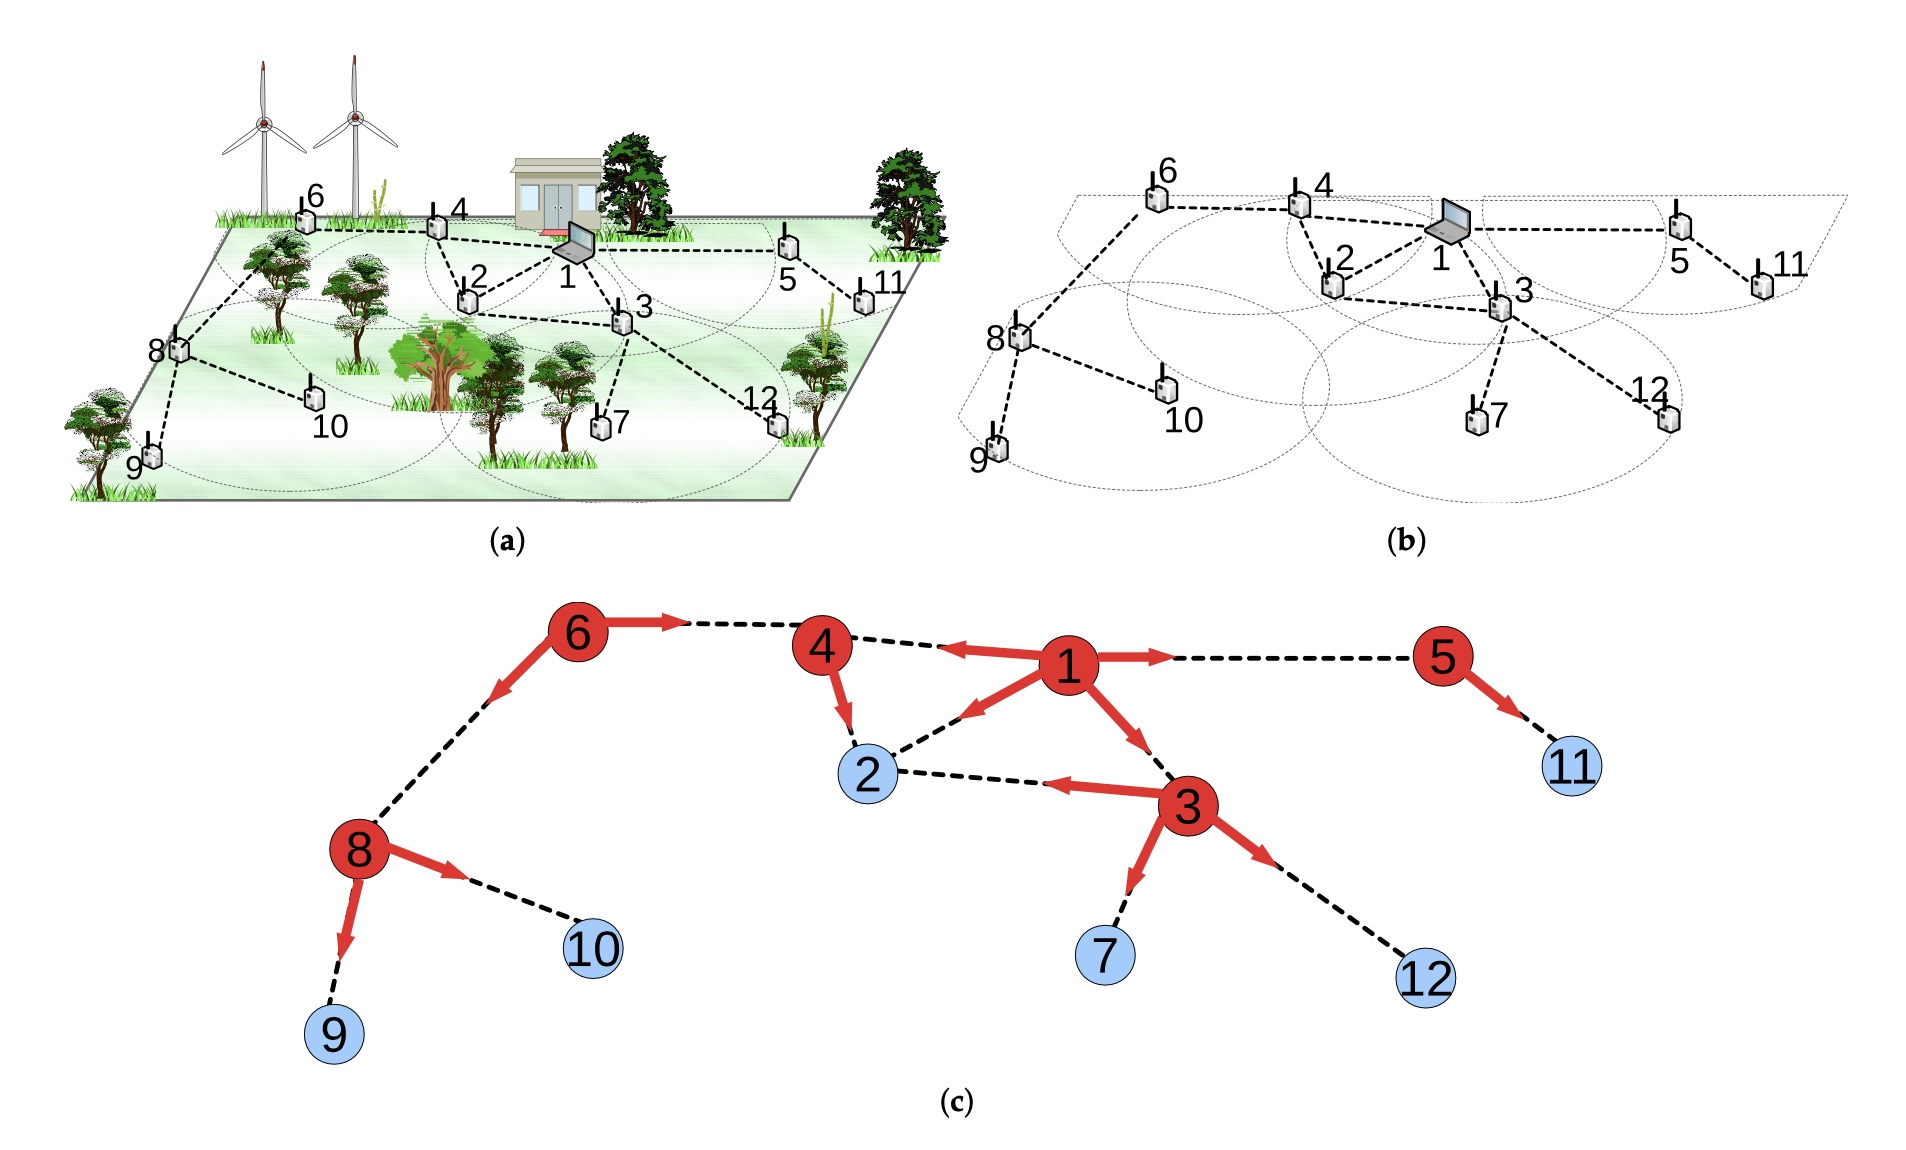

_<div class="alert alert-info">Figure 1. An example of link monitoring application for the vertex cover problem: (a) Deployment of a sample WSN; (b) Graph representation of the topology; (c) Link monitoring application on the topology</div>_

## Minimum Vertex Cover Mathematical Formulation

The Min Vertex Cover problem can be formulated as a Quadratic Unconstrained Binary Optimization (QUBO):

_Minimize:_
$\sum_{i \in V} x_i$

_Subject to:_
$(1 - x_i)(1 - x_j)=0 \quad  \forall (i,j) \in E_0$
_and_
$x_i \in \{0, 1\} \quad \forall i \in V$

_Where:_

- $x_i$ is a binary variable that equals 1 if node $i$ is in the cover and 0 otherwise
- $E_0$ is the set of all edges (connected and not connected)
- $V$ is the set of vertices in the graph


# Solving with Classiq

We go through the steps of solving the problem with Classiq, using QAOA algorithm [[2](#QAOA)].

## Quantum Approximate Optimization Algorithm (QAOA)

QAOA is a quantum algorithm designed to solve combinatorial optimization problems, making it an ideal candidate for tackling the Minimum Vertex Cover problem in large-scale WSNs.

Applying QAOA to the modeled graph, we iteratively adjust parameters to navigate the solution space and identify the minimum vertex cover. Quantum computing's unique ability to explore multiple solution candidates simultaneously accelerates the optimization process, significantly outperforming classical algorithms for complex problems.

**_<div class="alert alert-success">To solve the Link Monitoring Problem with Classiq we will: 1. Build a Classiq Model 2. Generate a parameterized Quantum Circuit 3. Execute the circuit and optimize parameters to get the optimal solution</div>_**

In [1]:
import classiq

In [2]:
from typing import cast

import networkx as nx
import numpy as np
import pyomo.core as pyo
from IPython.display import Markdown, display
from matplotlib import pyplot as plt

## Building the working example graph

We can start by building and viewing a modeled graph to fit the working example above:

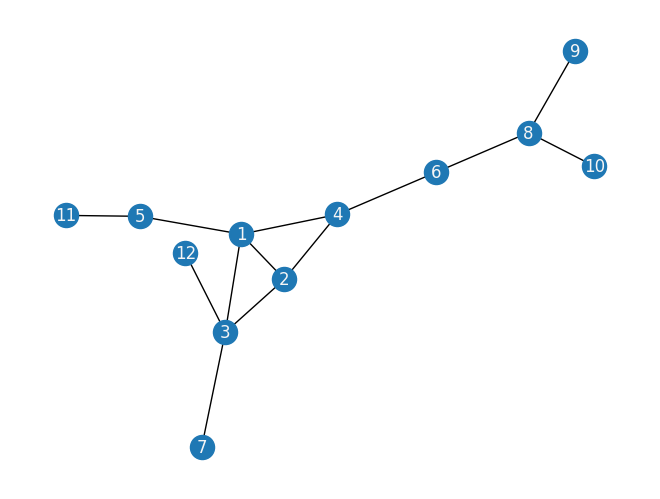

In [3]:
import networkx as nx

edge_dict = {
    1: [2, 3, 4, 5],
    2: [1, 3, 4],
    3: [1, 2, 7, 12],
    4: [1, 2, 6],
    5: [1, 11],
    6: [4, 8],
    7: [3],
    8: [6, 9, 10],
    9: [8],
    10: [8],
    11: [5],
    12: [3],
}

WSN_network_graph = nx.Graph()
WSN_network_graph.add_nodes_from([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
for u in range(1, 12):
    for v in edge_dict[u]:
        WSN_network_graph.add_edge(u, v)

nx.draw(WSN_network_graph, with_labels=True, font_color="whitesmoke")

## Building the optimization model from a graph input

To build the optimization model we will utilize Pyomo.
Pyomo is a Python-based, open-source optimization modeling language with a diverse set of optimization capabilities.
We will formalize our QUBO model into a pyomo model object.

**_Classiq seamlessly incorporates the pyomo object into its Model_**

We proceed by defining the pyomo model that will be used to build a Classiq Model.
Using the mathematical formulation defined above:

In [4]:
import networkx as nx
import pyomo.core as pyo


def mvc(graph: nx.Graph) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel()
    model.x = pyo.Var(graph.nodes, domain=pyo.Binary)
    nodes = list(graph.nodes())

    @model.Constraint(graph.edges)
    def full_cover(model, i, j):
        # all sets are covered
        return ((1 - model.x[i]) * (1 - model.x[j])) == 0

    def obj_expression(model):
        # number of nodes selected
        return sum(model.x.values())

    model.cost = pyo.Objective(rule=obj_expression, sense=pyo.minimize)

    return model

The model contains:

- Binary variable declaration for each node (model.x) indicating whether the variable is chosen for the set.
- Constraint rule – ensures that all edges are covered.
- Objective rule – minimize the number of nodes selected.

In [5]:
mvc_model = mvc(WSN_network_graph)

In [6]:
mvc_model.pprint()

2 Set Declarations
    full_cover_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :   13 : {(1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (3, 7), (3, 12), (4, 6), (5, 11), (6, 8), (8, 9), (8, 10)}
    x_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   12 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

1 Var Declarations
    x : Size=12, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary
          6 :     0 :  None :     1 : False :  True : Binary
          7 :     0 :  None :     1 : False :  True : Binary
          8 :    

Since node $1$ is our WSN sink node we will force it into the Vertex Cover solution as follows:

In [7]:
mvc_model.x[1].fixed = True
mvc_model.x[1].value = 1

**We are set to go!**

## 1. Build a Classiq Model

We will utilize `construct_combinatorial_optimization_model` function to create our Model object.

As input for this function we will define the quantum configuration of the QAOA algorithm though the `QAOAConfig` object where the number of repetitions (`num_layers`) is defined:

In [8]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=1)

For the classical optimization part of the QAOA algorithm we define the classical optimization configuration through the `OptimizerConfig` object where the maximum number of classical iterations (`max_iteration`) and the $\alpha$-parameter (`alpha_cvar`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)], are defined:

In [9]:
optimizer_config = OptimizerConfig(max_iteration=60, alpha_cvar=0.9)

Lastly, we load the Classiq model, based on the problem and algorithm parameters, which we can than use to solve the problem:

In [10]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=mvc_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

Our Classiq Model (`qmod`) already incorporates the QAOA execution logic. However, we can set the quantum backend we wish to execute on so the Classiq synthesis engine will take it into consideration when generating an optimized Quantum Circuit:

In [11]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

**_<div class="alert alert-success">That's it! Our Classiq Model is set!!</div>_**
We can write our Model to file and view all quantum configurations and execution logic.

In [12]:
with open("link_monitoring.qmod", "w") as f:
    f.write(qmod)

_The above file can also be loaded to our web IDE for further analysis and ease of execution._

## 2. Generate a parameterized Quantum Circuit

**_<div class="alert alert-success">Super simple! We can `synthesize` our Model and view the QAOA circuit (ansatz) used to solve the optimization problem:</div>_**

In [13]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/f41c0cd2-696c-4381-8a27-02b3bb52fe87?version=0.34.0.dev0%2B124706fb0e


## 3. Execute the circuit: optimize parameters to get the optimal solution

**_<div class="alert alert-success">To solve the problem using the generated circuit we just use the `execute` method:</div>_**

In [14]:
from classiq import execute

res = execute(qprog).result()

### Analyzing the execution results

#### Energy convergence

First, let's check the Energy convergence through the iterations:

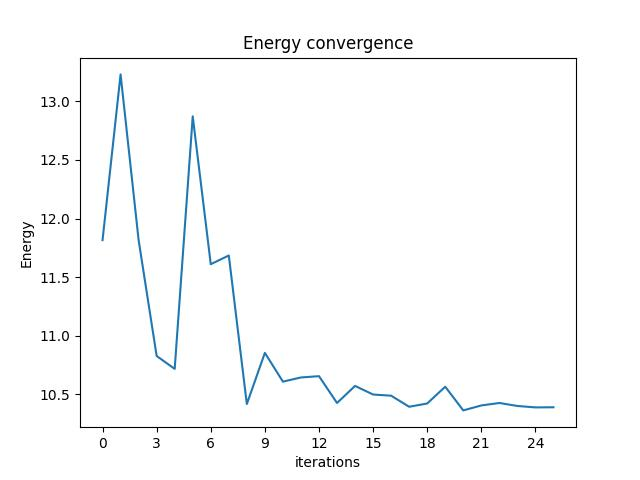

In [15]:
from classiq.execution import VQESolverResult

vqe_result = VQESolverResult.parse_obj(res[1].value)
vqe_result.convergence_graph

#### Optimization Results

We can also examine the statistics of the algorithm:

In [16]:
import pandas as pd

optimization_result = pd.DataFrame.from_records(res[0].value)
optimization_result.sort_values(by="cost", ascending=True).head(5)

,probability,cost,solution,count
49,0.003,5.0,"[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0]",3
7,0.006,5.0,"[1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0]",6
8,0.006,5.0,"[0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0]",6
23,0.004,6.0,"[0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0]",4
369,0.001,6.0,"[1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0]",1


And the histogram:

array([[<Axes: title={'center': 'cost'}>]], dtype=object)

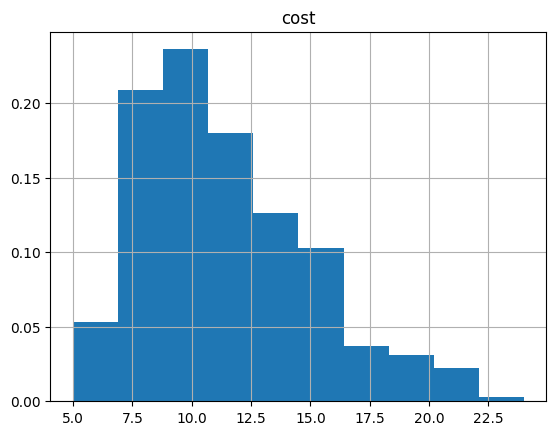

In [17]:
optimization_result.hist("cost", weights=optimization_result["probability"])

#### Plot the optimal solution!

In [18]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]

In [19]:
best_solution

[1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0]

In [20]:
WSN_network_graph.nodes

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12))

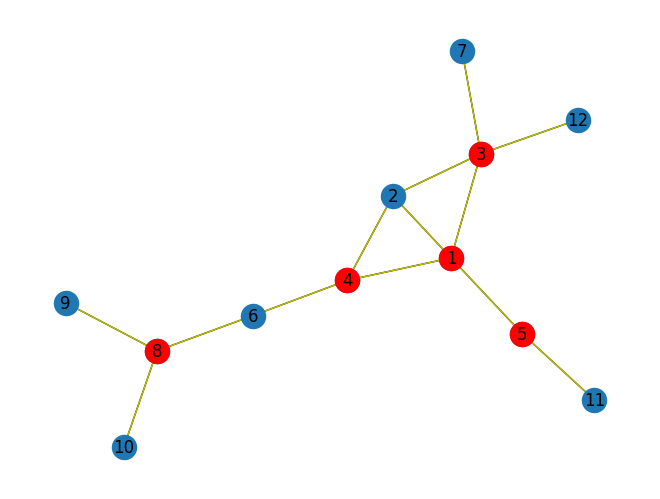

In [21]:
def draw_solution(graph: nx.Graph, solution: list):
    solution_nodes = [v for v in graph.nodes if solution[v - 1]]
    solution_edges = [
        (u, v) for u, v in graph.edges if u in solution_nodes or v in solution_nodes
    ]
    nx.draw_kamada_kawai(graph, with_labels=True)
    nx.draw_kamada_kawai(
        graph,
        nodelist=solution_nodes,
        edgelist=solution_edges,
        node_color="r",
        edge_color="y",
    )


draw_solution(WSN_network_graph, best_solution)

**_<div class="alert alert-success">We obtained a set of vertices that form the minimum vertex cover! These vertices correspond to the critical sensors that need to be monitored and maintained for optimal link connectivity. The outcome is a comprehensive link monitoring strategy that ensures efficient data transmission while conserving energy.</div>_**

#### Larger scale models

TBD

**_<div class="alert alert-success">Solving the WSN link monitoring challenge through the Minimum Vertex Cover problem and QAOA highlights the transformative potential of quantum computing in addressing real-world optimization problems. By combining graph theory, quantum algorithms, and practical applications, we open the door to enhanced connectivity, energy efficiency, and the seamless functioning of wireless sensor networks. As technology continues to evolve, the synergy between these methodologies will shape the future of network optimization.</div>_**


## References

<a id='WSN'>[1]</a>: [Self-Stabilizing Capacitated Vertex Cover Algorithms for Internet-of-Things-Enabled Wireless Sensor Networks](https://www.researchgate.net/publication/360630980_Self-Stabilizing_Capacitated_Vertex_Cover_Algorithms_for_Internet-of-Things-Enabled_Wireless_Sensor_Networks)

<a id='MVC'>[2]</a>: [Solving Vertex Cover via Ising Model on a
Neuromorphic Processor](https://vmonaco.com/papers/Solving%20Vertex%20Cover%20via%20Ising%20Model%20on%20a%20Neuromorphic%20Processor.pdf)

<a id='cvar'>[3]</a>: [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
